In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Tutorial link: https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [3]:
dataframe = pd.read_csv("final.csv")

In [4]:
dataframe.dropna(inplace=True)

In [5]:
dataframe['target'] = dataframe['MB']

In [6]:
dataframe = dataframe.drop(['MB'], axis=1)

In [7]:
X = dataframe.drop(['target'], axis=1)
y = dataframe['target']

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
feature_columns = []

for header in ["H1SE1", "H1SE2", "H1SE3", "H1FS1", "H1FS2", "H1FS3", "H1FS4", "H1FS5", "H1FS7", "H1FS8", 
            "H1FS9", "H1FS11", "H1FS13", "H1FS14", "H1FS15", "H1FS17", "H1FS18", "H1FS19", "H1PF7", 
            "H1PF13", "H1PF14", "H1PF15", "H1PF16", "H1PF21", "H1PF30", "H1PF32", "H1PF33", "H1PF34", 
            "H1PF35", "H1PF36", "H1CO3", "H1CO6", "H1CO10", "H1NR3", "H1TO1", "H1TO3", "H1TO12", "H1TO13", 
            "H1TO20", "H1TO21", "H1TO23", "H1TO24", "H1TO27", "H1TO28", "H1DS1", "H1DS2", "H1DS3", "H1DS4",
            "H1DS5", "H1DS6", "H1DS7", "H1DS8", "H1DS9", "H1DS10", "H1DS11", "H1DS12", "H1DS13", "H1DS14",
            "H1DS15", "H1JO1", "H1JO3", "H1JO5", "H1JO7", "H1JO9", "H1JO10", "H1JO11", "H1JO12", "H1JO14",
            "H1JO17", "H1JO19", "H1JO20", "H1JO21", "H1JO23", "H1JO25", "H1JO26", "H1FV5", "H1FV7", 
            "H1FV8", "H1FV9", "H1SU1", "H1SU2"]:
    feature_columns.append(feature_column.numeric_column(header))


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [10]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer = tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],))  # This is for numeric inputs


In [11]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [12]:
model = tf.keras.Sequential([
    input_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])

In [13]:
def specificity(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), 'float'))
    false_positives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), 'float'))
    
    specificity = true_negatives / (true_negatives + false_positives + tf.keras.backend.epsilon())
    return specificity

In [14]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc'),
                  specificity,
                  tf.keras.metrics.Recall(name='sensitivity'),
                  f1_score
                      ]
             )

In [16]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
)

Epoch 1/10
122/122 [==============================] - 1s 4ms/step - loss: 0.2544 - accuracy: 0.9172 - auc: 0.7453 - specificity: 0.9683 - sensitivity: 0.4374 - f1_score: 0.5017 - val_loss: 0.1061 - val_accuracy: 0.9608 - val_auc: 0.9089 - val_specificity: 0.9782 - val_sensitivity: 0.7636 - val_f1_score: 0.7884
Epoch 2/10
122/122 [==============================] - 0s 1ms/step - loss: 0.0974 - accuracy: 0.9585 - auc: 0.9129 - specificity: 0.9795 - sensitivity: 0.7813 - f1_score: 0.8401 - val_loss: 0.0786 - val_accuracy: 0.9693 - val_auc: 0.9207 - val_specificity: 0.9831 - val_sensitivity: 0.8000 - val_f1_score: 0.8315
Epoch 3/10
122/122 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9751 - auc: 0.9460 - specificity: 0.9862 - sensitivity: 0.8617 - f1_score: 0.8795 - val_loss: 0.0702 - val_accuracy: 0.9677 - val_auc: 0.9316 - val_specificity: 0.9842 - val_sensitivity: 0.8242 - val_f1_score: 0.8643
Epoch 4/10
122/122 [==============================] - 0s 2ms/ste

In [17]:
model.evaluate(
    test_ds,
)

41/41 [==============================] - 0s 582us/step - loss: 0.0759 - accuracy: 0.9739 - auc: 0.9343 - specificity: 0.9885 - sensitivity: 0.8580 - f1_score: 0.8764


[0.07585874944925308,
 0.9738662838935852,
 0.9342604875564575,
 0.9884998798370361,
 0.857988178730011,
 0.87640780210495]

In [18]:
import shap


In [19]:
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 56ms/step


  0%|          | 0/1301 [00:00<?, ?it/s]

685/685 [==============================] - 0s 567us/step


In [20]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(1301, 81)


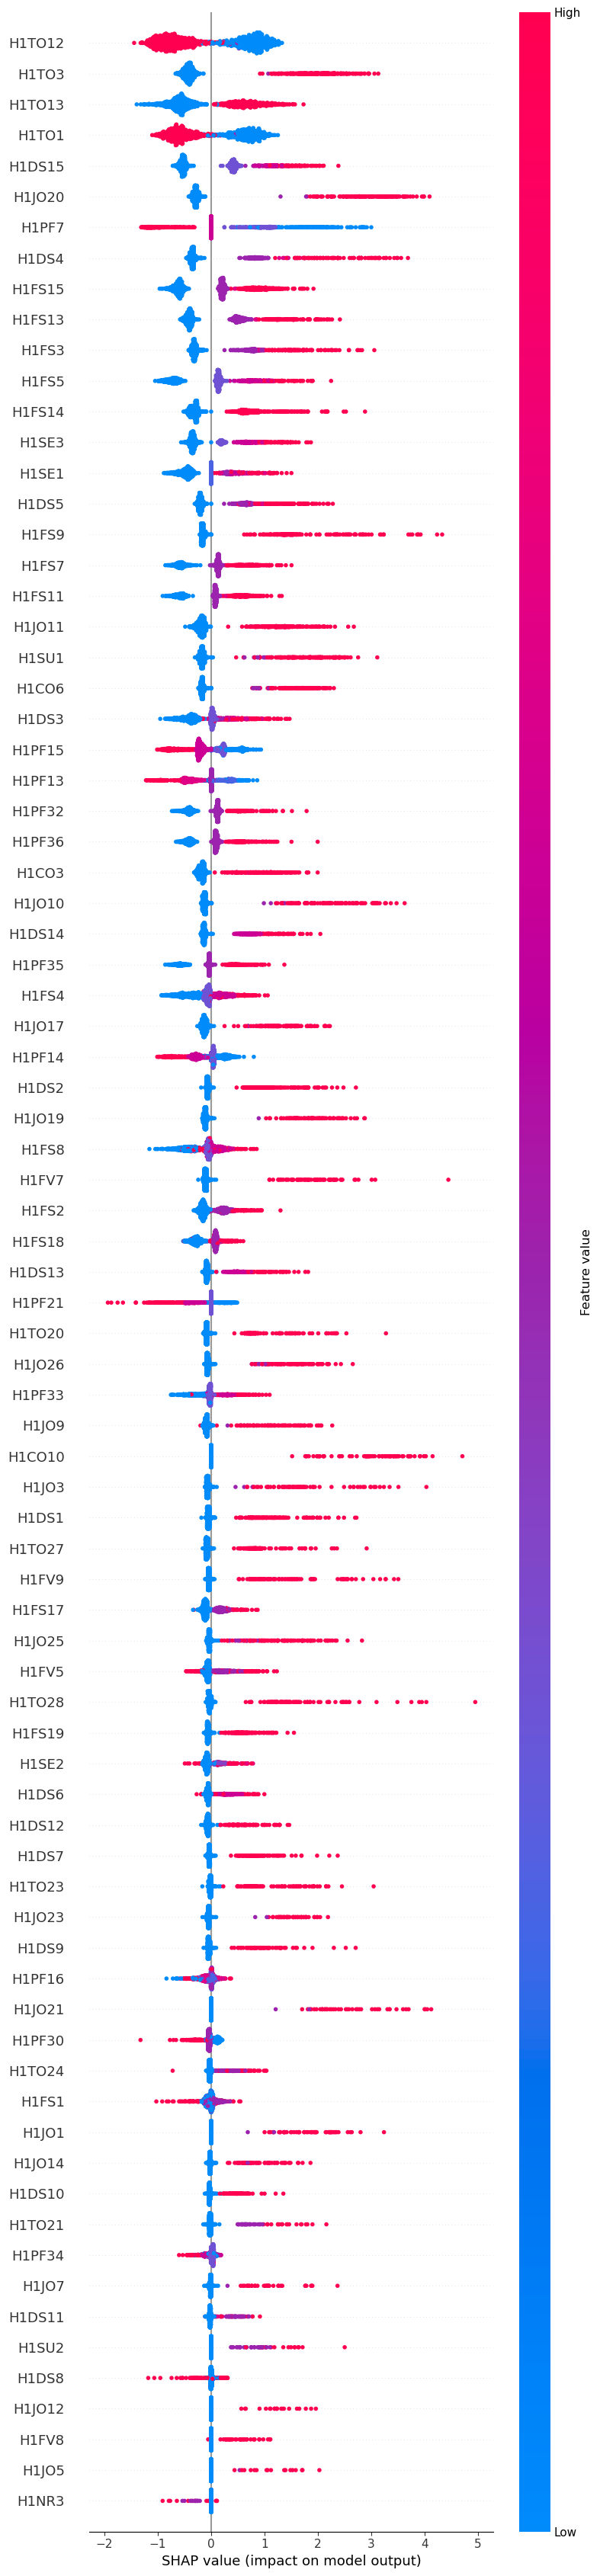

In [21]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])